<a href="https://colab.research.google.com/github/Shubh4545/StackExchange-question-quality-detection/blob/main/StackExchange_question_quality_detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**0.Import Libraries**


In [113]:
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
nltk.download('punkt')
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler 
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#**1.Dataset Creation**



In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1.Here we need to extract [data](https://drive.google.com/drive/folders/15xd3v1mSaeGILRnpUUa2V-r2AbGp26kH) from xml file to csv file in correct format/structure. we used ElementTree to extract data from xml file. and we store extracted data to dataset.csv**

In [72]:

# Parse the XML file
tree = ET.parse('/content/drive/MyDrive/COLAB/Posts.xml')
root = tree.getroot()

# Define the columns of the dataset
columns = ['Id', 'PostTypeId', 'AcceptedAnswerId','Score', 'ViewCount','Tags','Title','Body', 'AnswerCount', 'CommentCount', 'FavoriteCount']

# Create an empty list to store the data
data = []

# Iterate through each row in the XML file
for row in root.findall('.//row'):

    # Extract the values of the attributes
    id_val = row.get('Id')
    post_type_id = row.get('PostTypeId')
    accepted_answer_id = row.get('AcceptedAnswerId')
    score = row.get('Score')
    Title = row.get('Title')
    view_count = row.get('ViewCount')
    Tags = row.get('Tags')
    body = row.get('Body')
    answer_count = row.get('AnswerCount')
    comment_count = row.get('CommentCount')
    favorite_count = row.get('FavoriteCount')
    
    # Append the attribute values as a list to the data list
    if int(post_type_id) == 1:
             data.append([id_val, post_type_id, accepted_answer_id,score,view_count,Tags,Title, body,answer_count, comment_count, favorite_count])

# Create a Pandas DataFrame from the data list and the columns list
df = pd.DataFrame(data, columns=columns)

df.to_csv('dataset.csv', index=False)
print('dataset.csv created ')

dataset.csv created 


**2.we need to sample the dataset because dataset is very big so we are using Simple Random Sampling**

In [73]:


# load your data into a DataFrame (replace 'data.csv' with your data file name)
df = pd.read_csv('dataset.csv',encoding='iso-8859-1')

# randomly sample 50000 rows from the DataFrame
sample = df.sample(n=50000, replace=False, random_state=42)
print('Shape of dataset',sample.shape)
# print the sample
sample.to_csv('sampled_dataset.csv')
print('sampled_dataset created')



Shape of dataset (50000, 11)
sampled_dataset created


**3.create sample dataset**

**we need to create dependent feature based on independent features score and AnswerCount. we are using some conditions**

In [74]:
# load your data into a DataFrame (replace 'data.csv' with your data file name)
df = pd.read_csv('sampled_dataset.csv')

# create a new column that labels each question as "good quality", "low quality", or "very-low quality"
def label_question(row):
    if row['Score'] > 5 and row['AnswerCount'] > 0:
        return 'good quality'
    elif row['Score'] >= 0 and row['Score'] <=5 and row['AnswerCount'] >= 0:
        return 'low quality'
    elif row['Score'] < 0:
        return 'very low quality'
    else:
        return 'unknown'

df['question_quality'] = df.apply(label_question, axis=1)

# save dataframe to csv file
df.to_csv("complete_dataset.csv")
print('complete_dataset created')


complete_dataset created


In [75]:
data=pd.read_csv("complete_dataset.csv")

#**2.Data Cleaning**

**Dropping not related/important column**

**As we are are not using columns AnswerCount and Score because we used them to create dependend column so we are dropping them also**

In [76]:
col=['Unnamed: 0','Unnamed: 0.1','Id','PostTypeId','AcceptedAnswerId','AnswerCount','Score']
data.drop(col,inplace =True,axis=1)
 

**We are converting Title and body into length of body and title data**

**Clean tags or unwanted charecters this from Body column text**



In [77]:
# Remove <p> and </p> tags from the 'Body' column
data['Body'] = data['Body'].str.replace('<p>', '').str.replace('</p>', '')
data.head()

,ViewCount,Tags,Title,Body,CommentCount,FavoriteCount,question_quality
0,165,<electromagnetism><electromagnetic-induction>,What is doing work in eddy current braking?,Suppose we throw a metallic plate through the ...,0,NaN,low quality
1,15804,<newtonian-mechanics><classical-mechanics><flu...,Why is a beam reach the fastest point of sail ...,I've heard that a beam reach (perpendicular to...,4,5.0,good quality
2,965,<condensed-matter><solid-state-physics><diffra...,What does $d$-spacing between planes in a crys...,I have trouble understanding the meaning of $d...,1,NaN,low quality
3,110,<string-theory><topology><branes><calabi-yau>,D-brane wrapping in the geometric transition f...,"In Stefan Metzger's thesis (<a href=""https://a...",1,1.0,low quality
4,59,<homework-and-exercises><electromagnetism><mag...,Show $2(B \cdot \nabla)B = \nabla |B|^2$ when ...,I was able to show for myself that \n<span cla...,2,NaN,low quality


**We are adding features character count and word count for the 'Title' column and 'Body' column**

In [78]:
# Calculate the character count and word count for the 'Title' column and 'Body' column
data['Title_Text_Length'] = data['Title'].str.len()


data['Body_Text_Length'] = data['Body'].str.len()

data['Body_Sentences_Count'] = data['Body'].apply(lambda x: len(str(x).split('.')) if isinstance(x, str) else 0)
data.head()

,ViewCount,Tags,Title,Body,CommentCount,FavoriteCount,question_quality,Title_Text_Length,Body_Text_Length,Body_Sentences_Count
0,165,<electromagnetism><electromagnetic-induction>,What is doing work in eddy current braking?,Suppose we throw a metallic plate through the ...,0,NaN,low quality,43,840,9
1,15804,<newtonian-mechanics><classical-mechanics><flu...,Why is a beam reach the fastest point of sail ...,I've heard that a beam reach (perpendicular to...,4,5.0,good quality,66,2139,12
2,965,<condensed-matter><solid-state-physics><diffra...,What does $d$-spacing between planes in a crys...,I have trouble understanding the meaning of $d...,1,NaN,low quality,63,445,4
3,110,<string-theory><topology><branes><calabi-yau>,D-brane wrapping in the geometric transition f...,"In Stefan Metzger's thesis (<a href=""https://a...",1,1.0,low quality,82,1477,11
4,59,<homework-and-exercises><electromagnetism><mag...,Show $2(B \cdot \nabla)B = \nabla |B|^2$ when ...,I was able to show for myself that \n<span cla...,2,NaN,low quality,95,628,8


In [79]:
df=data.copy()

**Drop Title and Body Columns**

**We are removing tags column because i have checked tags column only increasing complexity rather inhancing accuracy**

In [80]:
col=['Title','Body','Tags']
data.drop(col,inplace =True,axis=1)

In [81]:
data.isnull().sum()

ViewCount                   0
CommentCount                0
FavoriteCount           29054
question_quality            0
Title_Text_Length           0
Body_Text_Length            0
Body_Sentences_Count        0
dtype: int64

**As in FavoriteCount more than 50% data is Nan we should drop that column**

**Other column null data very less so we can drop that rows**

In [82]:
data.shape

(50000, 7)

In [83]:
data.drop('FavoriteCount',inplace=True,axis=1)
data.shape

(50000, 6)

**Check Duplicates**

In [84]:
data.duplicated().sum()   #as there are no duplicated data

0

In [85]:
data.describe()

,ViewCount,CommentCount,Title_Text_Length,Body_Text_Length,Body_Sentences_Count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,1328.180280,2.389200,57.130680,873.786940,8.21548
std,5967.521876,2.876333,24.526157,806.070576,8.07531
min,3.000000,0.000000,15.000000,32.000000,1.00000
25%,83.000000,0.000000,39.000000,372.000000,3.00000
50%,219.000000,2.000000,53.000000,650.000000,6.00000
75%,731.000000,3.000000,71.000000,1109.000000,11.00000
max,434533.000000,34.000000,163.000000,23809.000000,250.00000


**we can see there are outlires but in this case we are not removing it beacuse it might be high quality question that have text length larger means question expplaned better or in good way vice-versa low quality**

**Check data type of dataset**

In [86]:
data.dtypes

ViewCount                int64
CommentCount             int64
question_quality        object
Title_Text_Length        int64
Body_Text_Length         int64
Body_Sentences_Count     int64
dtype: object

As data type is object should only for question_quality other than that integer int/float must

In [87]:
data

,ViewCount,CommentCount,question_quality,Title_Text_Length,Body_Text_Length,Body_Sentences_Count
0,165,0,low quality,43,840,9
1,15804,4,good quality,66,2139,12
2,965,1,low quality,63,445,4
3,110,1,low quality,82,1477,11
4,59,2,low quality,95,628,8
...,...,...,...,...,...,...
49995,421,4,good quality,100,653,7
49996,392,0,low quality,121,1991,17
49997,279,5,low quality,81,717,1
49998,3091,1,good quality,41,504,3


#**3.Exploratory Data Analysis**

In [88]:
print('Dataset shape : ',data.shape)

Dataset shape :  (50000, 6)


In [89]:
data["question_quality"].value_counts()

low quality         41422
good quality         5531
very low quality     2893
unknown               154
Name: question_quality, dtype: int64

In [90]:
# percentage of class present in target variable(y) 
print("percentage of low_quality,good_quality and very low quality \n",data["question_quality"].value_counts()/len(data)*100)

percentage of low_quality,good_quality and very low quality 
 low quality         82.844
good quality        11.062
very low quality     5.786
unknown              0.308
Name: question_quality, dtype: float64


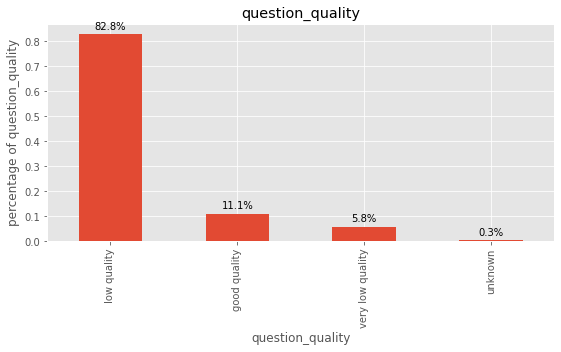

In [91]:
plt.style.use("ggplot")

plt.figure(figsize=(20,4))
ax = plt.subplot(121)
data['question_quality'].value_counts(normalize=True).plot(kind="bar")
plt.xlabel('question_quality')
plt.ylabel("percentage of question_quality")
plt.title('question_quality')
    
    # Add percentage labels to the top of each bar
for p in ax.patches:
    ax.text(p.get_x()+p.get_width()/2., p.get_height()+0.02, f"{p.get_height()*100:.1f}%", ha="center")


**question_quality data is inbalenced 82.8 : 11 : 5.8 : 0.3**

**Unknown data is very less we can remove/replace it**

In [92]:
data = data[data['question_quality'] != 'unknown']

In [93]:
data.replace({'question_quality' : { 'very low quality' : 0, 'good quality' : 2, 'low quality' : 1 }},inplace=True)

/usr/local/lib/python3.9/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2103

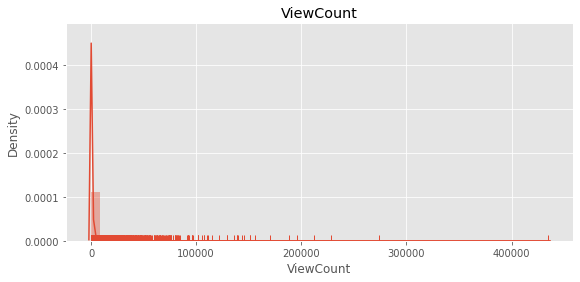

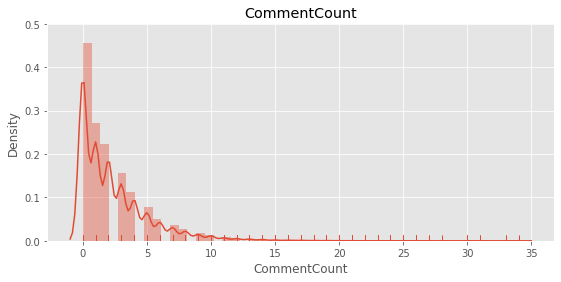

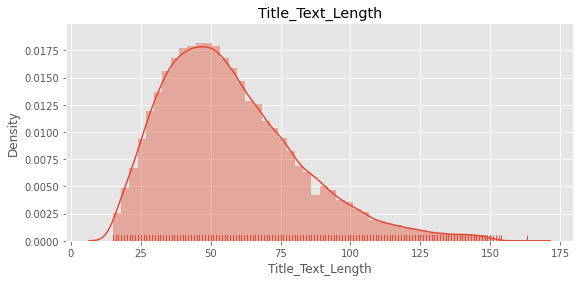

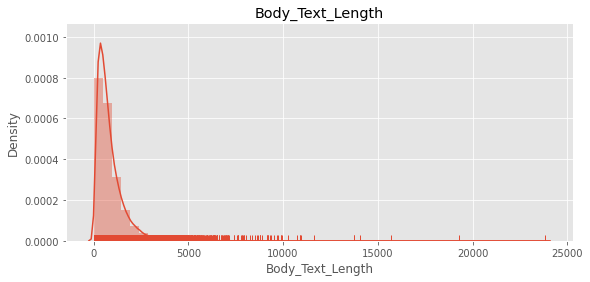

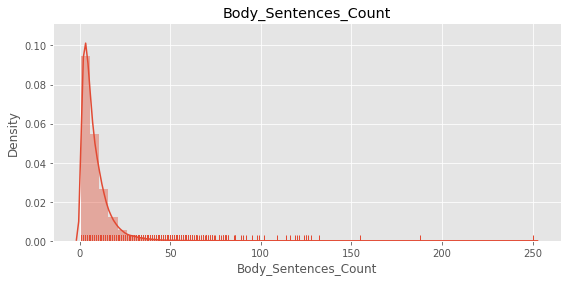

In [94]:
# plotting histogram for each numerical variable
column_names = list(data.columns)
column_names.remove('question_quality')
plt.style.use("ggplot")
for column in column_names:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.distplot(data[column], kde=True, rug=True)
    plt.title(column)

**Most of columns data is skewed except Title_char_count and Title_word_count**

**Skewness we can not do anything about it because we cannot remove outlires which are very usefull in this case**

<AxesSubplot:>

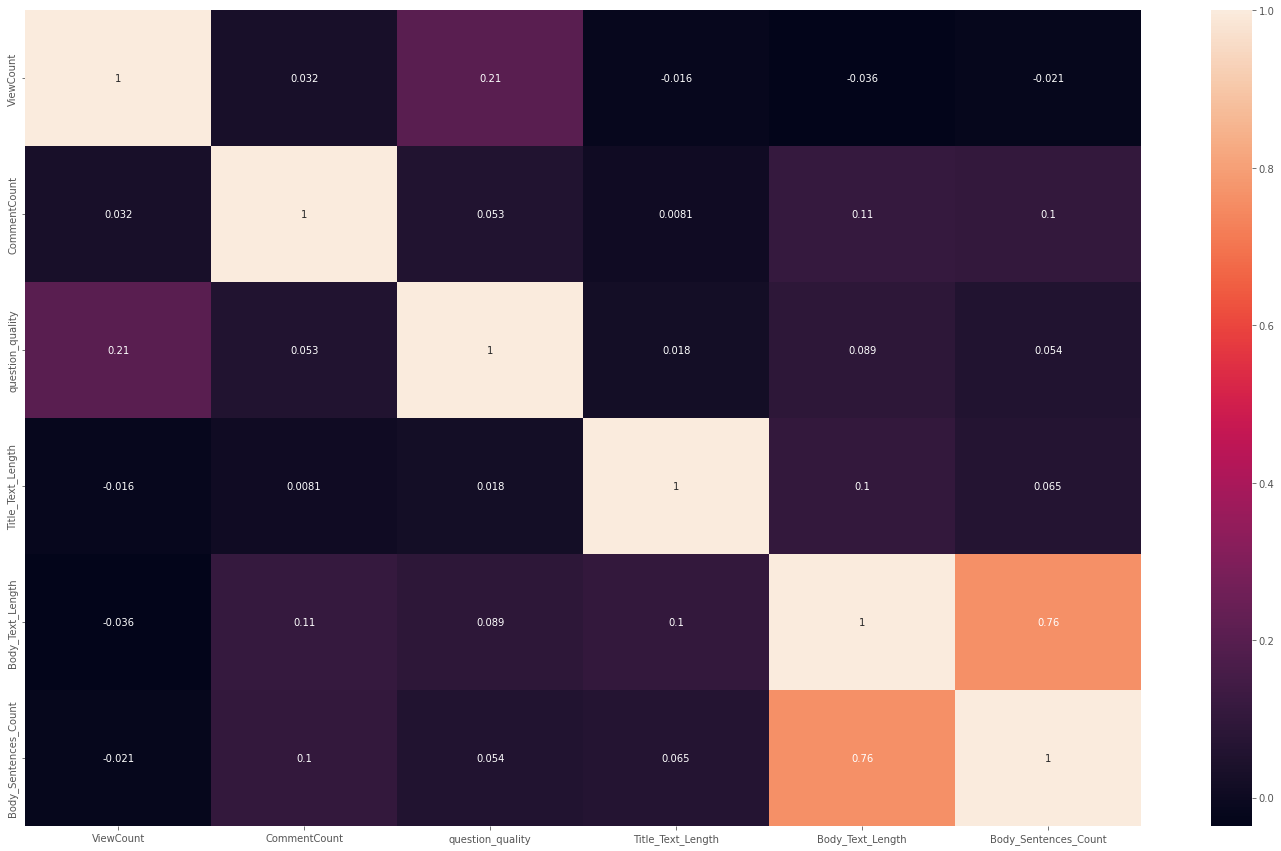

In [96]:
plt.figure(figsize=(25,15))
sns.heatmap(data.corr(), annot=True)

In [97]:
data

,ViewCount,CommentCount,question_quality,Title_Text_Length,Body_Text_Length,Body_Sentences_Count
0,165,0,1,43,840,9
1,15804,4,2,66,2139,12
2,965,1,1,63,445,4
3,110,1,1,82,1477,11
4,59,2,1,95,628,8
...,...,...,...,...,...,...
49995,421,4,2,100,653,7
49996,392,0,1,121,1991,17
49997,279,5,1,81,717,1
49998,3091,1,2,41,504,3


#**4.Split Dataset into Train and Test**

In [100]:
X= data.drop(['question_quality'],axis=1)
y= data['question_quality']

"""from imblearn.over_sampling import SMOTENC

cat_features = np.array([0, 1, 2])
# Define the SMOTENC object with a sampling strategy for each class
sampling_strategy = {0: 10000, 1: 35000, 2: 10000}
smote_nc = SMOTENC(sampling_strategy=sampling_strategy, categorical_features=cat_features, random_state=42)

# Apply SMOTE-NC oversampling to the training data
X_resampled, y_resampled = smote_nc.fit_resample(p, q)

# Check the class distribution of the resampled data
print(y_resampled.value_counts())
"""

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


#**5.Scalling**

In [101]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#**6.Model**

**1.Logistic Regression**

In [110]:
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)

train_predicted = lr_model.predict(X_train)
test_predicted = lr_model.predict(X_test)

print("The accuracy of Logistic Regression on train data is: ", accuracy_score(y_train, train_predicted)*100, "%")
print("The accuracy of Logistic Regression on test data is: ", accuracy_score(y_test, test_predicted)*100, "%")

print("\nPrecision (train): ", precision_score(y_train, train_predicted, average='weighted'))
print("Recall (train): ", recall_score(y_train, train_predicted, average='weighted'))
print("F1-score (train): ", f1_score(y_train, train_predicted, average='weighted'))

print("\nPrecision (test): ", precision_score(y_test, test_predicted, average='weighted'))
print("Recall (test): ", recall_score(y_test, test_predicted, average='weighted'))
print("F1-score (test): ", f1_score(y_test, test_predicted, average='weighted'))

The accuracy of Logistic Regression on train data is:  83.45310815666546 %
The accuracy of Logistic Regression on test data is:  83.5258358662614 %

Precision (train):  0.7632584078557809
Recall (train):  0.8345310815666547
F1-score (train):  0.7726141243776821

Precision (test):  0.7661469260256334
Recall (test):  0.835258358662614
F1-score (test):  0.7729107354191166


**These results indicate that the Logistic Regression model is performing similarly on both the training and test sets, with accuracies of approximately 83.5%. This suggests that the model is not overfitting to the training data and is generalizing reasonably well to new, unseen data.**

In [108]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)  
rf_model.fit(X_train, y_train)  
train_predicted=rf_model.predict(X_train)
test_predicted = rf_model.predict(X_test)
print("The accuracy of Random Forest on train data is : ", accuracy_score(y_train, train_predicted)*100, "%")
print("The accuracy of Random Forest on test data is : ", accuracy_score(y_test, test_predicted)*100, "%")
print()
print()
# Calculate precision, recall, and F1-score on the training set
train_precision = precision_score(y_train, train_predicted, average='weighted')
train_recall = recall_score(y_train, train_predicted, average='weighted')
train_f1 = f1_score(y_train, train_predicted, average='weighted')

# Calculate precision, recall, and F1-score on the test set
test_precision = precision_score(y_test, test_predicted, average='weighted')
test_recall = recall_score(y_test, test_predicted, average='weighted')
test_f1 = f1_score(y_test, test_predicted, average='weighted')

# Print the results
print("Precision (train): ", train_precision)
print("Recall (train): ", train_recall)
print("F1-score (train): ", train_f1)
print()
print("Precision (test): ", test_precision)
print("Recall (test): ", test_recall)
print("F1-score (test): ", test_f1)

The accuracy of Random Forest on train data is :  100.0 %
The accuracy of Random Forest on test data is :  83.12462006079028 %


Precision (train):  1.0
Recall (train):  1.0
F1-score (train):  1.0

Precision (test):  0.764288684177136
Recall (test):  0.8312462006079028
F1-score (test):  0.7838667416268802


**The results show that the Random Forest Classifier model has perfect precision, recall, and F1-score on the training set, but slightly lower performance on the test set. This suggests that the model may be overfitting to the training data.**

**The precision, recall, and F1-score values on the test set are also helpful for evaluating the performance of the model on new, unseen data. The F1-score of 0.78 on the test set indicates that the model's overall performance is reasonable, but there may be some room for improvement.**

In [111]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Define the number of folds
n_folds = 3

# Define the multi-class classification model
model = RandomForestClassifier()

# Define the cross-validation method
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')

# Print the scores for each fold
print("Cross-validation scores:", scores)

# Calculate and print the mean and standard deviation of the scores
print("Mean accuracy:", np.mean(scores))
print("Standard deviation:", np.std(scores))


Cross-validation scores: [0.83142754 0.8331628  0.83213963]
Mean accuracy: 0.8322433257590586
Standard deviation: 0.0007122032926167554


In [114]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer

count_vec = CountVectorizer(max_features=10000)
bow = count_vec.fit_transform(df['Body'])
X = bow
y = df['question_quality']

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# create an instance of the SMOTE class
smote = SMOTE()

# fit and apply SMOTE to the training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# convert the resampled X_train to a dense numpy array
X_train_resampled = X_train_resampled.toarray()

# train your model on the resampled training data
model = MultinomialNB().fit(X_train_resampled, y_train_resampled)

# evaluate the model on the test set
y_pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))


Accuracy: 0.7087333333333333
F1 score: 0.31208166992321584


**The accuracy of the model on the test set is 70.87%, and the F1-score is 0.312. It seems that the model is not performing very well, especially in terms of F1-score. This may indicate a class imbalance issue, where the minority class (e.g., low-quality questions) is not well represented in the training data.**

**To address this issue, you can try using different resampling techniques, such as oversampling or undersampling, or using a different algorithm that can handle class imbalance more effectively, such as the BalancedRandomForestClassifier or the XGBoost classifier with the scale_pos_weight parameter.**

**The three models we have evaluated are Random Forest, Logistic Regression, and Multinomial Naive Bayes.**

**Random Forest:**

Train accuracy: 100%

Test accuracy: 83.12%

Train Precision, Recall, and F1-score: 1.0, 1.0, 1.0

Test Precision, Recall, and F1-score: 0.76, 0.83, 0.78

**Logistic Regression:**

Train accuracy: 83.45%

Test accuracy: 83.53%

Train Precision, Recall, and F1-score: 0.76, 0.83, 0.77

Test Precision, Recall, and F1-score: 0.77, 0.84, 0.77

**Multinomial Naive Bayes with SMOTE:**

Test accuracy: 70.87%

Test F1-score: 0.31

**Based on the accuracy and F1-score, Random Forest and Logistic Regression perform better than Multinomial Naive Bayes. Random Forest has the highest train accuracy and precision, recall, and F1-score for both train and test datasets. Logistic Regression also has high accuracy and F1-score, and its precision and recall are higher than those of Random Forest on the test dataset.**

**Logistic regression is a popular and widely used classification algorithm. It is a linear model that works well when there is a linear relationship between the input variables and the output. In the above case, logistic regression was able to achieve a good accuracy score on both the train and test datasets, and also achieved good scores for precision, recall, and F1-score.**

**Additionally, logistic regression is a simple and interpretable model, which can be an advantage in situations where understanding the relationship between the input variables and the output is important. It is also computationally efficient and can handle large datasets.**

**Overall, logistic regression was a good choice for the given problem because it was able to perform well on the data, while also being simple and interpretable.**